In [1]:
from transformers import AutoProcessor, Pix2StructForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments
from torch.utils.data import Dataset, DataLoader, random_split
from datasets import Dataset as HFDataset
from PIL import Image
import json
import os
from tqdm import tqdm
import torch
import os

# Set CUDA environment variable to avoid memory fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

class ChartDataset(Dataset):
    def __init__(self, images_dir, annotations_dir, processor):
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.processor = processor
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        annotation_file = image_file.replace('.jpg', '.json')

        # Load image
        image_path = os.path.join(self.images_dir, image_file)
        image = Image.open(image_path).convert("RGB")

        # Load annotation
        annotation_path = os.path.join(self.annotations_dir, annotation_file)
        with open(annotation_path, 'r') as f:
            annotation = json.load(f)

        # Extract data-series from annotation
        data_series = annotation.get("data-series", [])

        # Preprocess the image with the text "Generate data series"
        inputs = self.processor(images=image, text="Generate data series:", return_tensors="pt")

        return {
            "flattened_patches": inputs["flattened_patches"].squeeze(),
            "labels": torch.tensor(self.processor.tokenizer(json.dumps(data_series), padding="max_length", max_length=512, truncation=True).input_ids)  # Reduced max_length
        }

# Custom data collator
def custom_data_collator(features):
    flattened_patches = torch.stack([feature["flattened_patches"] for feature in features])
    labels = torch.nn.utils.rnn.pad_sequence([feature["labels"] for feature in features], batch_first=True, padding_value=-100)
    return {"flattened_patches": flattened_patches, "labels": labels}

# Paths to your data directories
images_dir = "/kaggle/input/sortrd-chart-data/sorted_data/sorted_data/horizontal_bar/images"
annotations_dir = "/kaggle/input/sortrd-chart-data/sorted_data/sorted_data/horizontal_bar/annotations"

# Load processor and model
model = Pix2StructForConditionalGeneration.from_pretrained("google/deplot")
processor = AutoProcessor.from_pretrained("google/deplot")

# Prepare dataset
dataset = ChartDataset(images_dir, annotations_dir, processor)

# Split dataset into training and evaluation
train_size = int(0.8 * len(dataset))
eval_size = len(dataset) - train_size
train_dataset, eval_dataset = random_split(dataset, [train_size, eval_size])

# Use DataLoader for lazy loading and batching
data_loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)




In [2]:
# Training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="/kaggle/working/deplot_finetuned",
    eval_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=1,  # Further reduced batch size
    per_device_eval_batch_size=1,  # Further reduced batch size
    num_train_epochs=5,
    save_strategy="epoch",
    save_total_limit=2,
    predict_with_generate=True,
    fp16=True,
    logging_dir="/kaggle/working/logs",
    logging_steps=100,
    push_to_hub=False,
    dataloader_num_workers=2,  # Reduced workers
    ddp_find_unused_parameters=False,
    report_to=["none"],
    gradient_accumulation_steps=2,  # Reduced gradient accumulation
    no_cuda=False,
    load_best_model_at_end=True
)



In [3]:
# Initialize trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,  # Training dataset
    eval_dataset=eval_dataset,    # Evaluation dataset
    tokenizer=processor.tokenizer,
    data_collator=custom_data_collator
)

# Train model
trainer.train()

# Save the model
model.save_pretrained("/kaggle/working/deplot_finetuned")
processor.save_pretrained("/kaggle/working/deplot_finetuned")

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
0,No log,4.227215
2,No log,3.683466
4,No log,3.581421


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0

[]

In [4]:
from transformers import AutoProcessor, Pix2StructForConditionalGeneration
from PIL import Image

# Load the fine-tuned model and processor
model = Pix2StructForConditionalGeneration.from_pretrained("/kaggle/working/deplot_finetuned")
processor = AutoProcessor.from_pretrained("/kaggle/working/deplot_finetuned")


In [5]:
from transformers import AutoProcessor, Pix2StructForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import pandas as pd
import json
import os
import torch

# Set CUDA environment variable to avoid memory fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

class CSVChartDataset(Dataset):
    def __init__(self, images_dir, annotations_csv, processor):
        self.images_dir = images_dir
        self.annotations = pd.read_csv(annotations_csv)
        self.processor = processor

    def __len__(self):
        return min(5000, len(self.annotations))  # Use only 1000 images for fine-tuning

    def __getitem__(self, idx):
        idx = idx + 110000
        row = self.annotations.iloc[idx]
        image_path = os.path.join(self.images_dir, os.path.basename(row["file_name"]))
        data_series = row["text"]

        # Convert the data-series to JSON-like format
        data_series_json = []
        for pair in data_series.split("<0x0A>"):
            if "|" in pair:
                x, y = pair.split("|")
                data_series_json.append({"x": float(x.strip()), "y": y.strip()})

        # Load image
        image = Image.open(image_path).convert("RGB")

        # Preprocess the image and data series
        inputs = self.processor(images=image, text="Generate data series:", return_tensors="pt")

        return {
            "flattened_patches": inputs["flattened_patches"].squeeze(),
            "labels": torch.tensor(
                self.processor.tokenizer(
                    json.dumps(data_series_json, ensure_ascii=False),
                    padding="max_length",
                    max_length=512,
                    truncation=True
                ).input_ids
            )
        }

# Custom data collator
def custom_data_collator(features):
    flattened_patches = torch.stack([feature["flattened_patches"] for feature in features])
    labels = torch.nn.utils.rnn.pad_sequence([feature["labels"] for feature in features], batch_first=True, padding_value=-100)
    return {"flattened_patches": flattened_patches, "labels": labels}

# Paths to your data directories
images_dir = "/kaggle/input/benetech-extra-generated-data/graphs_h"
annotations_csv = "/kaggle/input/benetech-extra-generated-data/metadata.csv"

# Load processor and model
model = Pix2StructForConditionalGeneration.from_pretrained("/kaggle/working/deplot_finetuned")  # Load previously fine-tuned model
processor = AutoProcessor.from_pretrained("/kaggle/working/deplot_finetuned")

# Prepare dataset
dataset = CSVChartDataset(images_dir, annotations_csv, processor)

# Split dataset into training and evaluation
train_size = int(0.8 * len(dataset))
eval_size = len(dataset) - train_size
train_dataset, eval_dataset = random_split(dataset, [train_size, eval_size])

# Training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="/kaggle/working/deplot_finetuned_v2",
    eval_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=5,
    save_strategy="epoch",
    save_total_limit=2,
    predict_with_generate=True,
    fp16=True,
    logging_dir="/kaggle/working/logs_v2",
    logging_steps=100,
    push_to_hub=False,
    dataloader_num_workers=2,
    ddp_find_unused_parameters=False,
    report_to=["none"],
    gradient_accumulation_steps=2,
    no_cuda=False,
    load_best_model_at_end=True
)

# Initialize trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor.tokenizer,
    data_collator=custom_data_collator
)

# Train model
trainer.train()

# Save the model
model.save_pretrained("/kaggle/working/deplot_finetuned_v2")
processor.save_pretrained("/kaggle/working/deplot_finetuned_v2")


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
1,0.026500,0.018001
2,0.006800,0.006822


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


RuntimeError: [enforce fail at inline_container.cc:603] . unexpected pos 492405184 vs 492405076

In [9]:
model.save_pretrained("/kaggle/working/deplot_finetuned_v2")
processor.save_pretrained("/kaggle/working/deplot_finetuned_v2")

[]

In [10]:
from transformers import AutoProcessor, Pix2StructForConditionalGeneration
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the fine-tuned model and processor
model = Pix2StructForConditionalGeneration.from_pretrained("/kaggle/working/deplot_finetuned_v2").to(device)
processor = AutoProcessor.from_pretrained("/kaggle/working/deplot_finetuned_v2")

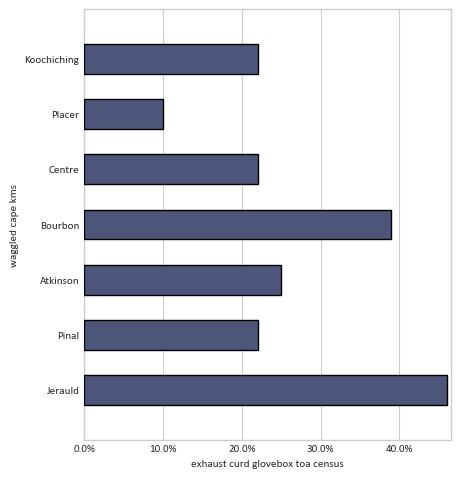

[{"x": 20.0, "y": "Koochiching"}, {"x": 10.0, "y": "Placer"}, {"x": 20.0, "y": "Centre"}, {"x": 40.0, "y": "Bourbon"}, {"x": 20.0, "y": "Atkinson"}, {"x": 20.0, "y": "Pinal"}, {"x": 50.0, "y": "Jerauld"}]


In [11]:
# Load an example image for prediction
image_path = "/kaggle/input/benetech-extra-generated-data/graphs_h/84359.jpg"
image = Image.open(image_path)
display(image)

inputs = processor(images=image, text="Generate data series:", return_tensors="pt")

# Move inputs to GPU
inputs = {key: value.to(device) for key, value in inputs.items()}

predictions = model.generate(**inputs, max_new_tokens=2048)
print(processor.decode(predictions[0], skip_special_tokens=True))

start loop:


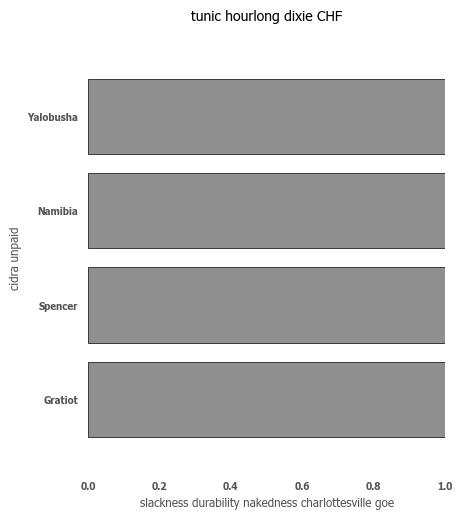

[{"x": 1.0, "y": "Yalobusha"}, {"x": 1.0, "y": "Namibia"}, {"x": 1.0, "y": "Spencer"}, {"x": 1.0, "y": "Gratiot"}]


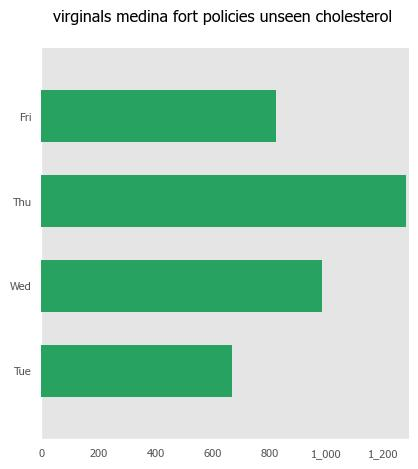

[{"x": 800.0, "y": "Fri"}, {"x": 1300.0, "y": "Thu"}, {"x": 1000.0, "y": "Wed"}, {"x": 700.0, "y": "Tue"}]


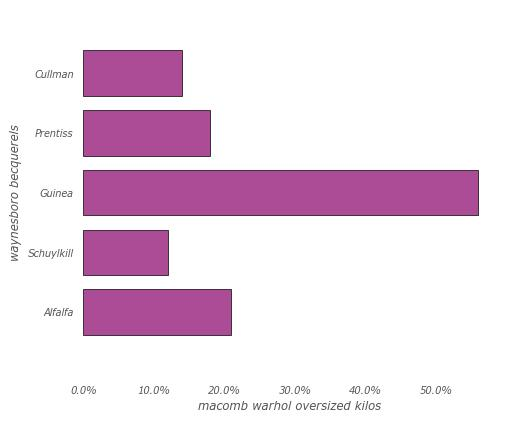

[{"x": 10.0, "y": "Cullman"}, {"x": 20.0, "y": "Prentiss"}, {"x": 60.0, "y": "Guinea"}, {"x": 10.0, "y": "Schuylkill"}, {"x": 20.0, "y": "Alfalfa"}]


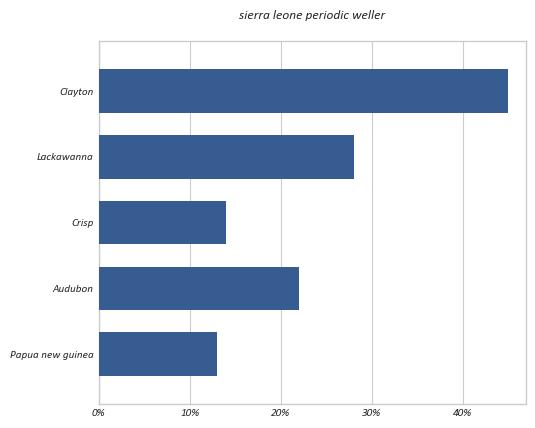

[{"x": 45.0, "y": "Clayton"}, {"x": 28.0, "y": "Lackawanna"}, {"x": 14.0, "y": "Crisp"}, {"x": 22.0, "y": "Audubon"}, {"x": 13.0, "y": "Papua new guinea"}]


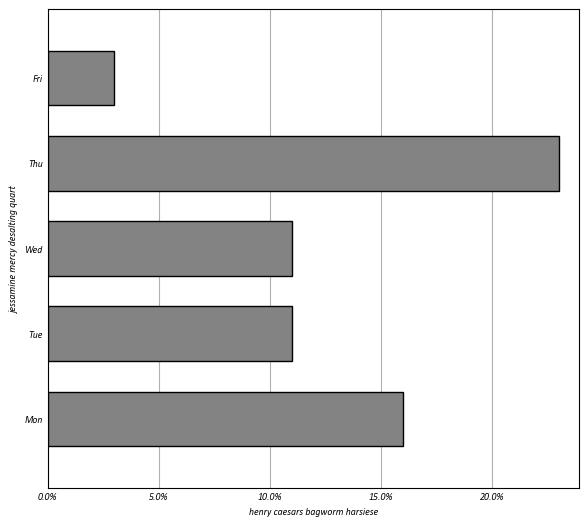

[{"x": 3.0, "y": "Fri"}, {"x": 24.0, "y": "Thu"}, {"x": 11.0, "y": "Wed"}, {"x": 11.0, "y": "Tue"}, {"x": 16.0, "y": "Mon"}]


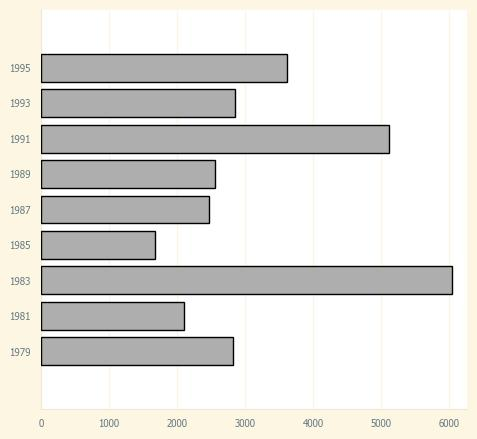

[{"x": 4000.0, "y": "1995"}, {"x": 3000.0, "y": "1993"}, {"x": 5000.0, "y": "1991"}, {"x": 3000.0, "y": "1989"}, {"x": 2000.0, "y": "1987"}, {"x": 2000.0, "y": "1985"}, {"x": 6000.0, "y": "1983"}, {"x": 2000.0, "y": "1981"}, {"x": 3000.0, "y": "1979"}]


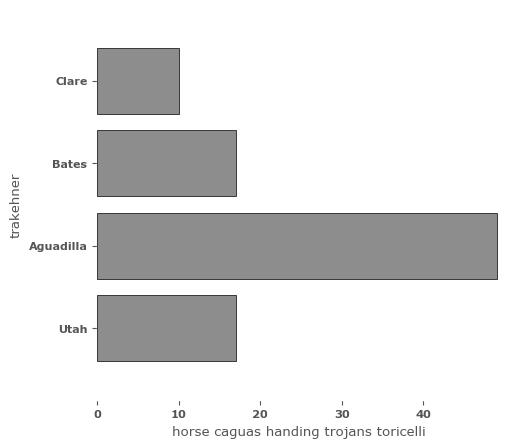

[{"x": 10.0, "y": "Clare"}, {"x": 20.0, "y": "Bates"}, {"x": 50.0, "y": "Aguadilla"}, {"x": 20.0, "y": "Utah"}]


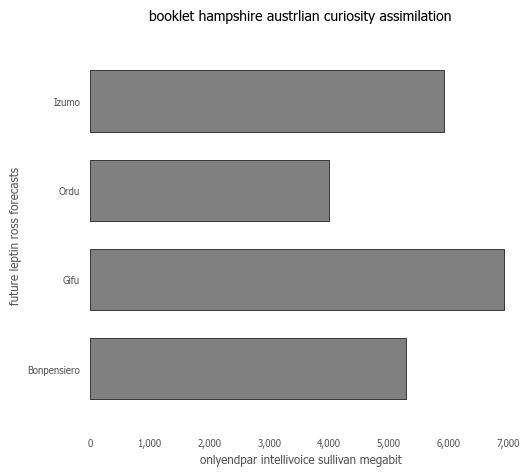

[{"x": 6000.0, "y": "Izumo"}, {"x": 4000.0, "y": "Ordu"}, {"x": 7000.0, "y": "Gifu"}, {"x": 5000.0, "y": "Blonpensiero"}]


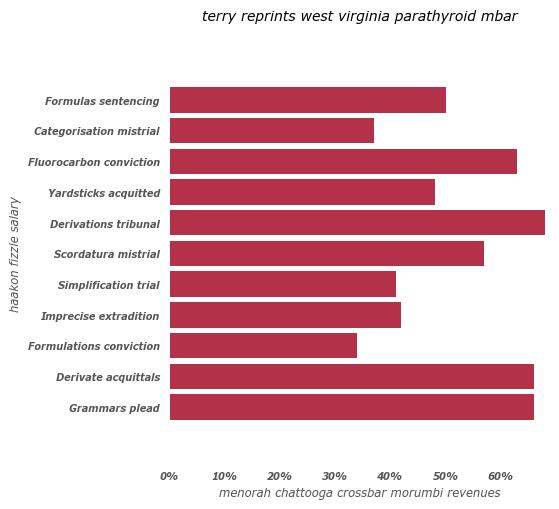

[{"x": 50.0, "y": "Formulas sentencing"}, {"x": 40.0, "y": "Categorisation mistrial"}, {"x": 60.0, "y": "Fluorocarbon conviction"}, {"x": 50.0, "y": "Yardsticks acquitted"}, {"x": 70.0, "y": "Derivations tribunal"}, {"x": 60.0, "y": "Scordatura mistrial"}, {"x": 40.0, "y": "Simplification trial"}, {"x": 40.0, "y": "Imprecise extraction"}, {"x": 30.0, "y": "Formulations conviction"}, {"x": 60.0, "y": "Derivate acquittals"}, {"x": 60.0, "y": "Grammars plead"}]


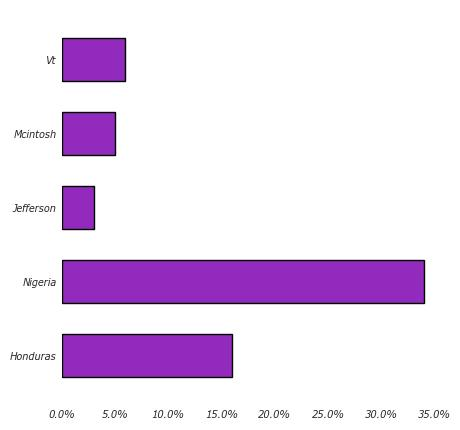

[{"x": 10.0, "y": "Vt"}, {"x": 0.0, "y": "Mcintosh"}, {"x": 0.0, "y": "Jefferson"}, {"x": 30.0, "y": "Nigeria"}, {"x": 20.0, "y": "Honduras"}]


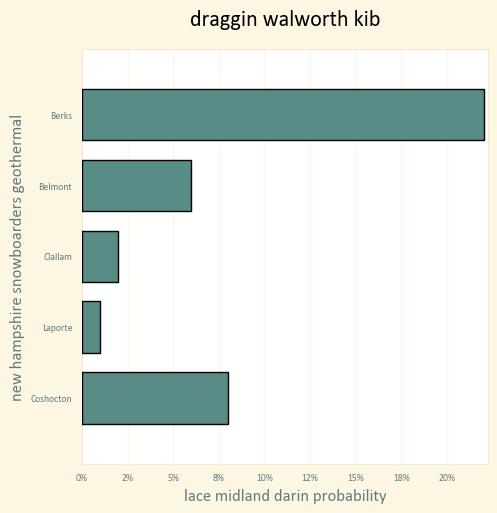

[{"x": 20.0, "y": "Berks"}, {"x": 10.0, "y": "Belmont"}, {"x": 0.0, "y": "Clallam"}, {"x": 0.0, "y": "Laporte"}, {"x": 10.0, "y": "Coshocton"}]


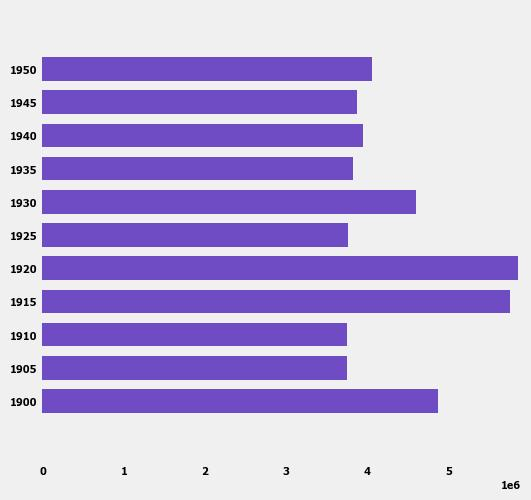

[{"x": 4000000.0, "y": "1950"}, {"x": 3900000.0, "y": "1945"}, {"x": 3900000.0, "y": "1940"}, {"x": 3700000.0, "y": "1935"}, {"x": 4600000.0, "y": "1930"}, {"x": 3700000.0, "y": "1925"}, {"x": 5800000.0, "y": "1920"}, {"x": 5700000.0, "y": "1915"}, {"x": 3700000.0, "y": "1910"}, {"x": 3700000.0, "y": "1905"}, {"x": 4800000.0, "y": "1900"}]


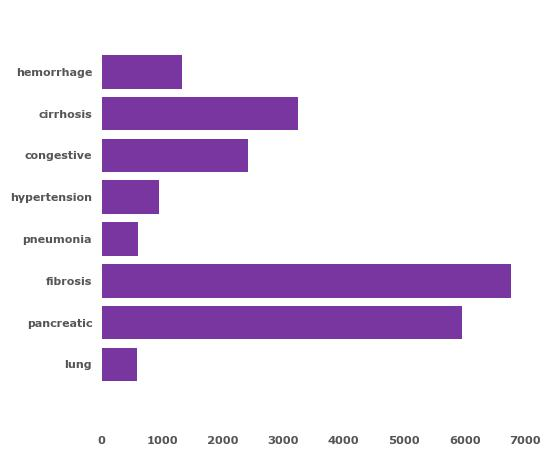

[{"x": 1000.0, "y": "hemorrhage"}, {"x": 3000.0, "y": "dirrhosis"}, {"x": 2000.0, "y": "congestive"}, {"x": 1000.0, "y": "hypertension"}, {"x": 1000.0, "y": "pneumonia"}, {"x": 7000.0, "y": "fibrosis"}, {"x": 6000.0, "y": "pancreatic"}, {"x": 1000.0, "y": "lung"}]


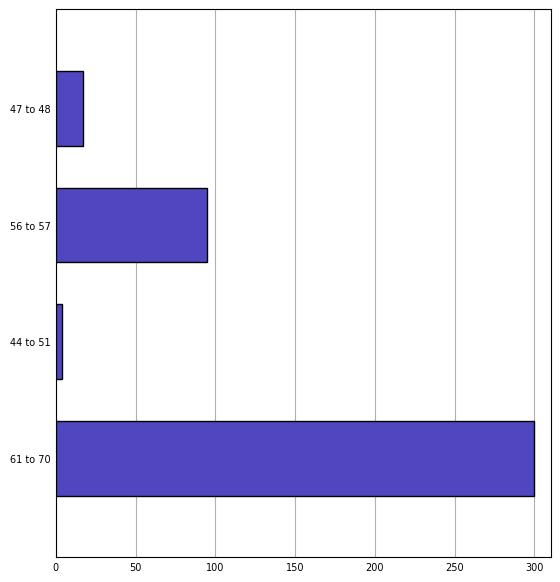

[{"x": 0.0, "y": "47 to 48"}, {"x": 100.0, "y": "56 to 57"}, {"x": 0.0, "y": "44 to 51"}, {"x": 300.0, "y": "61 to 70"}]


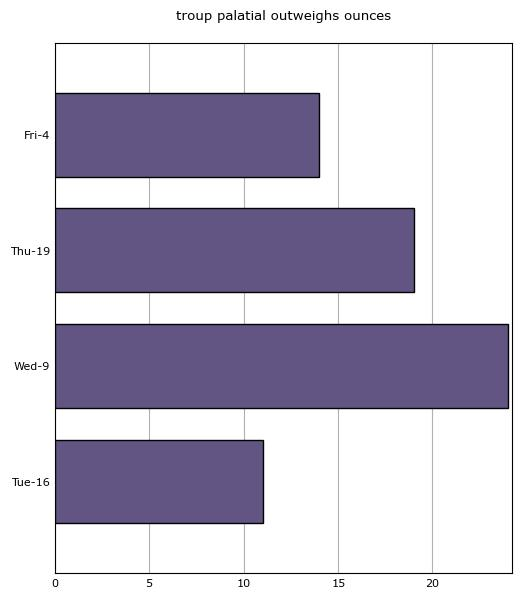

[{"x": 14.0, "y": "Fri-4"}, {"x": 19.0, "y": "Thu-19"}, {"x": 24.0, "y": "Wed-9"}, {"x": 11.0, "y": "Tue-16"}]


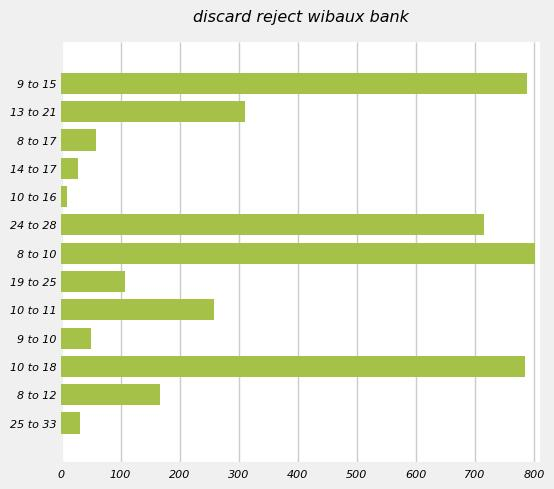

[{"x": 800.0, "y": "9 to 15"}, {"x": 300.0, "y": "13 to 21"}, {"x": 100.0, "y": "8 to 17"}, {"x": 0.0, "y": "14 to 17"}, {"x": 0.0, "y": "10 to 16"}, {"x": 700.0, "y": "24 to 28"}, {"x": 800.0, "y": "8 to 10"}, {"x": 100.0, "y": "19 to 25"}, {"x": 300.0, "y": "10 to 11"}, {"x": 100.0, "y": "9 to 10"}, {"x": 800.0, "y": "10 to 18"}, {"x": 200.0, "y": "8 to 12"}, {"x": 0.0, "y": "25 to 33"}]


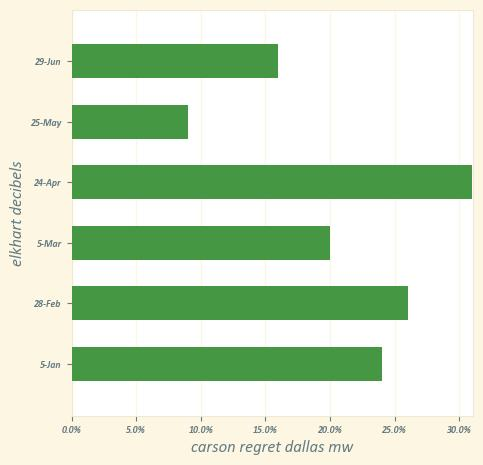

[{"x": 16.0, "y": "29-Jun"}, {"x": 9.0, "y": "25-May"}, {"x": 31.0, "y": "24-Apr"}, {"x": 20.0, "y": "5-Mar"}, {"x": 26.0, "y": "28-Feb"}, {"x": 24.0, "y": "5-Jan"}]


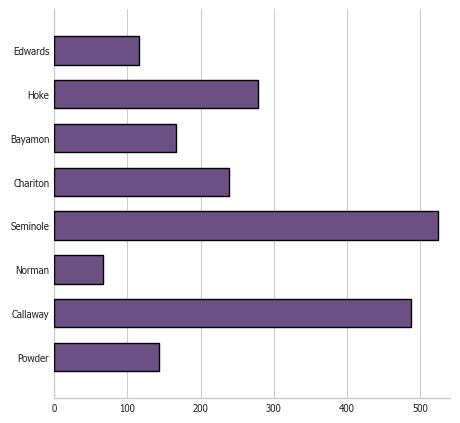

[{"x": 100.0, "y": "Edwards"}, {"x": 300.0, "y": "Hoke"}, {"x": 200.0, "y": "Bayamon"}, {"x": 200.0, "y": "Chariton"}, {"x": 500.0, "y": "Seminole"}, {"x": 100.0, "y": "Norman"}, {"x": 500.0, "y": "Callaway"}, {"x": 100.0, "y": "Powder"}]


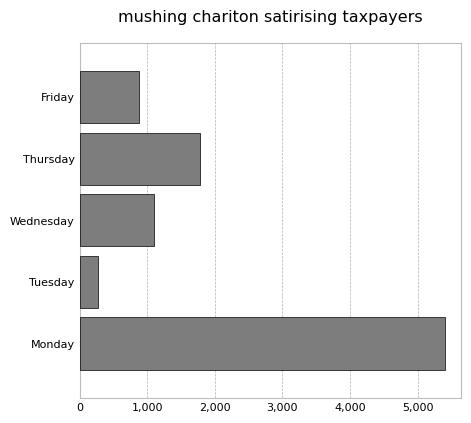

[{"x": 1000.0, "y": "Friday"}, {"x": 2000.0, "y": "Thursday"}, {"x": 1000.0, "y": "Wednesday"}, {"x": 0.0, "y": "Tuesday"}, {"x": 5000.0, "y": "Monday"}]


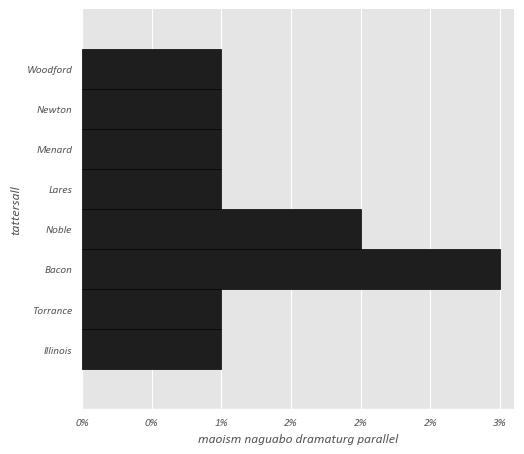

[{"x": 1.0, "y": "Woodford"}, {"x": 1.0, "y": "Newton"}, {"x": 1.0, "y": "Menard"}, {"x": 1.0, "y": "Lares"}, {"x": 2.0, "y": "Noble"}, {"x": 3.0, "y": "Bacon"}, {"x": 1.0, "y": "Torrance"}, {"x": 1.0, "y": "Illinois"}]


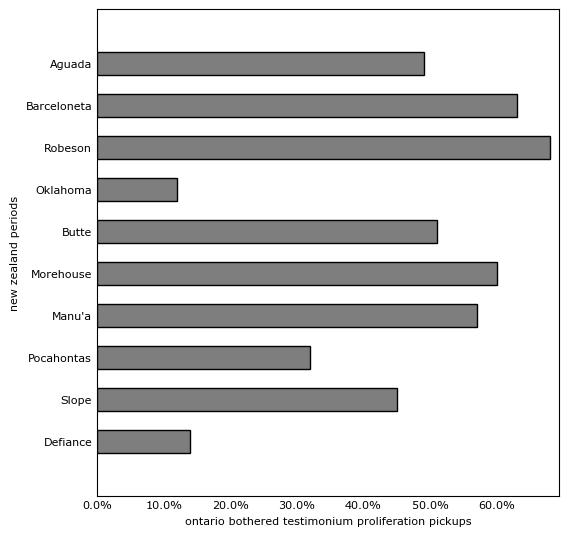

[{"x": 50.0, "y": "Aguada"}, {"x": 60.0, "y": "Barceloneta"}, {"x": 70.0, "y": "Robeson"}, {"x": 10.0, "y": "Oklahoma"}, {"x": 50.0, "y": "Butte"}, {"x": 60.0, "y": "Morehouse"}, {"x": 60.0, "y": "Manu'a"}, {"x": 30.0, "y": "Pocahontas"}, {"x": 40.0, "y": "Slope"}, {"x": 10.0, "y": "Defiance"}]


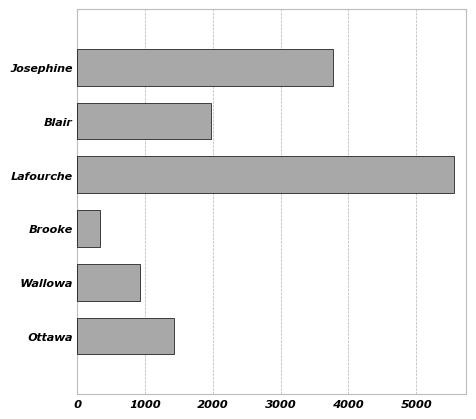

[{"x": 4000.0, "y": "Josephine"}, {"x": 2000.0, "y": "Blair"}, {"x": 6000.0, "y": "Lafourche"}, {"x": 0.0, "y": "Brooke"}, {"x": 1000.0, "y": "Wallowa"}, {"x": 1000.0, "y": "Ottawa"}]


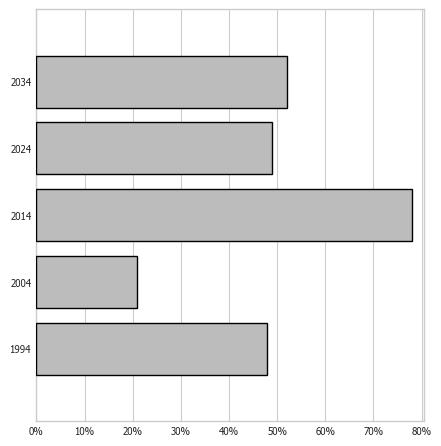

[{"x": 50.0, "y": "2034"}, {"x": 50.0, "y": "2024"}, {"x": 80.0, "y": "2014"}, {"x": 20.0, "y": "2004"}, {"x": 50.0, "y": "1994"}]


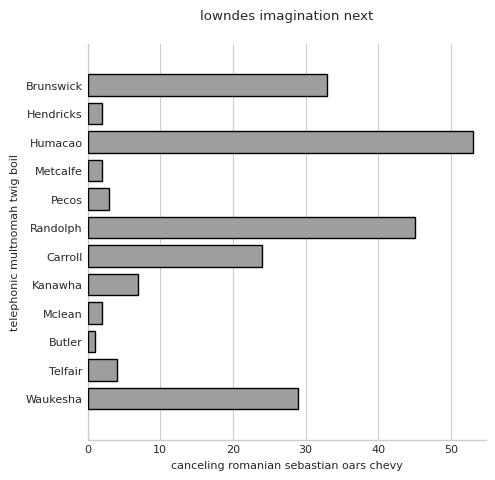

[{"x": 30.0, "y": "Brunswick"}, {"x": 0.0, "y": "Hendricks"}, {"x": 50.0, "y": "Humacao"}, {"x": 0.0, "y": "Metcalfe"}, {"x": 0.0, "y": "Pecos"}, {"x": 50.0, "y": "Randolph"}, {"x": 20.0, "y": "Carroll"}, {"x": 10.0, "y": "Kanawha"}, {"x": 0.0, "y": "Mclean"}, {"x": 0.0, "y": "Butler"}, {"x": 0.0, "y": "Telfair"}, {"x": 30.0, "y": "Waukesha"}]


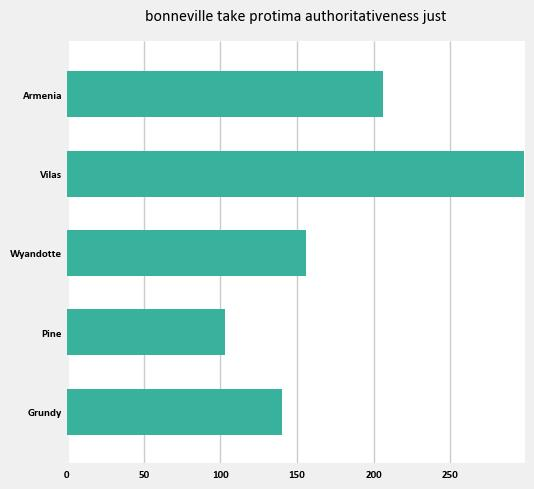

[{"x": 200.0, "y": "Armenia"}, {"x": 300.0, "y": "Vilas"}, {"x": 150.0, "y": "Wyandotte"}, {"x": 100.0, "y": "Pine"}, {"x": 140.0, "y": "Grundy"}]


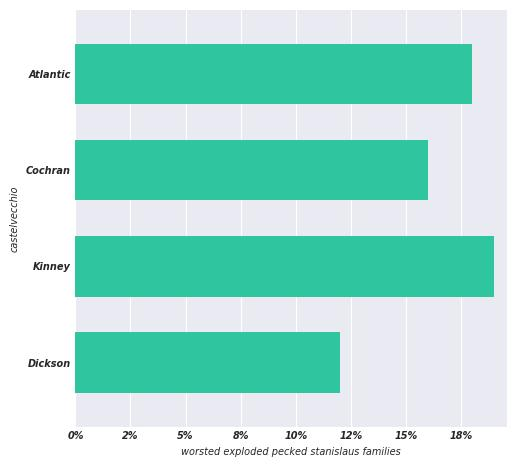

[{"x": 18.0, "y": "Atlantic"}, {"x": 16.0, "y": "Cochran"}, {"x": 19.0, "y": "Kinney"}, {"x": 12.0, "y": "Dickson"}]


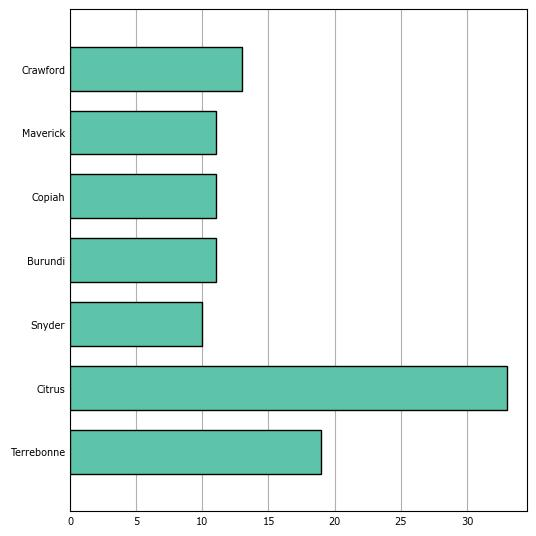

[{"x": 13.0, "y": "Crawford"}, {"x": 11.0, "y": "Mayerick"}, {"x": 11.0, "y": "Copiah"}, {"x": 11.0, "y": "Burundi"}, {"x": 10.0, "y": "Snyder"}, {"x": 33.0, "y": "Citrus"}, {"x": 19.0, "y": "Terrebonne"}]


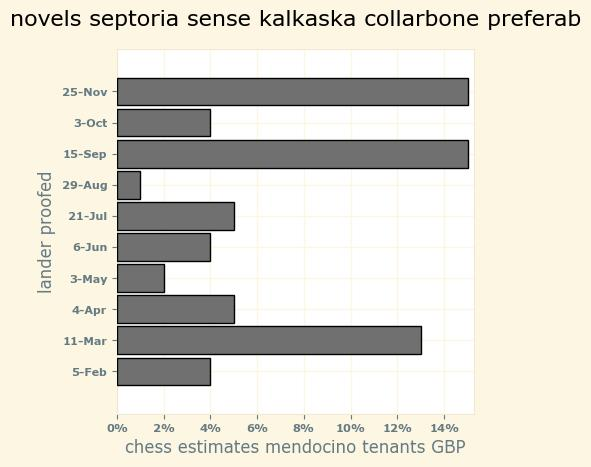

[{"x": 15.0, "y": "25-Nov"}, {"x": 4.0, "y": "3-Oct"}, {"x": 15.0, "y": "15-Sep"}, {"x": 1.0, "y": "29-Aug"}, {"x": 5.0, "y": "21-Jul"}, {"x": 4.0, "y": "6-Jun"}, {"x": 2.0, "y": "3-May"}, {"x": 5.0, "y": "4-Apr"}, {"x": 13.0, "y": "11-Mar"}, {"x": 4.0, "y": "5-Feb"}]


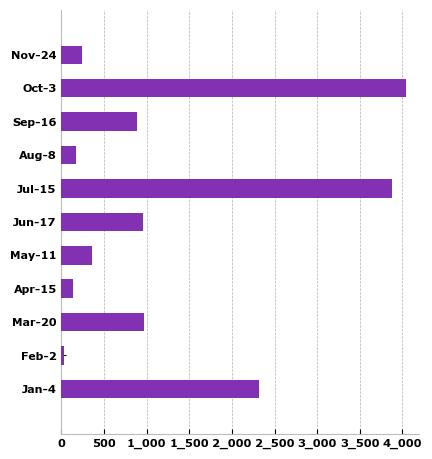

[{"x": 0.0, "y": "Nov-24"}, {"x": 4000.0, "y": "Oct-3"}, {"x": 1000.0, "y": "Sep-16"}, {"x": 0.0, "y": "Aug-8"}, {"x": 4000.0, "y": "Jul-15"}, {"x": 1000.0, "y": "Jun-17"}, {"x": 0.0, "y": "May-11"}, {"x": 0.0, "y": "Apr-15"}, {"x": 1000.0, "y": "Mar-20"}, {"x": 0.0, "y": "Feb-2"}, {"x": 2000.0, "y": "Jan-4"}]


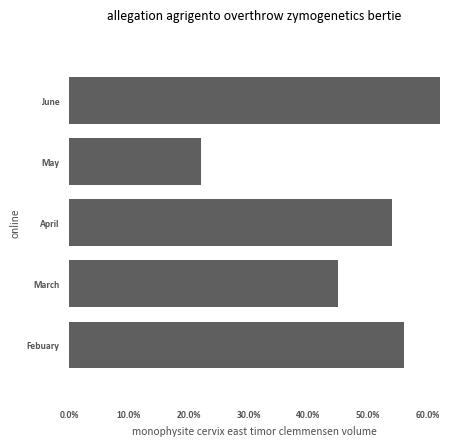

[{"x": 60.0, "y": "June"}, {"x": 20.0, "y": "May"}, {"x": 50.0, "y": "April"}, {"x": 40.0, "y": "March"}, {"x": 60.0, "y": "Febuary"}]


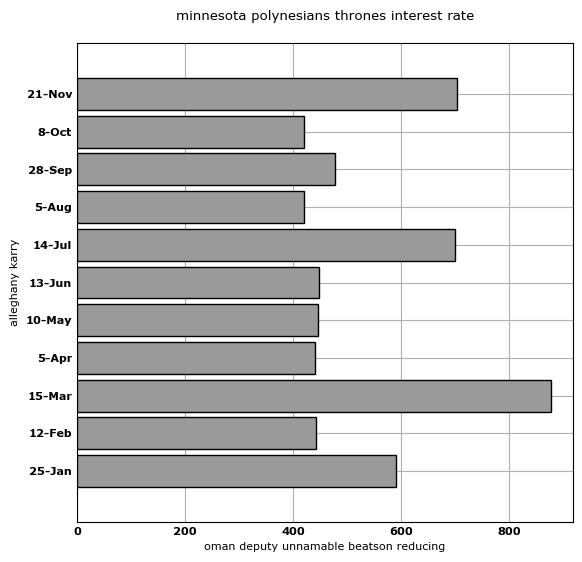

[{"x": 700.0, "y": "21-Nov"}, {"x": 400.0, "y": "8-Oct"}, {"x": 500.0, "y": "28-Sep"}, {"x": 400.0, "y": "5-Aug"}, {"x": 700.0, "y": "14-Jul"}, {"x": 400.0, "y": "13-Jun"}, {"x": 400.0, "y": "10-May"}, {"x": 400.0, "y": "5-Apr"}, {"x": 900.0, "y": "15-Mar"}, {"x": 400.0, "y": "12-Feb"}, {"x": 600.0, "y": "25-Jan"}]


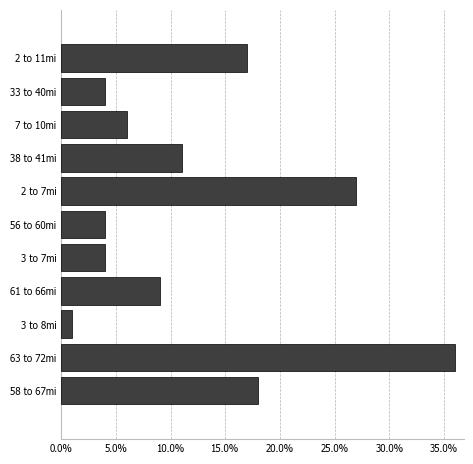

[{"x": 17.0, "y": "2 to 11mi"}, {"x": 4.0, "y": "33 to 40mi"}, {"x": 6.0, "y": "7 to 10mi"}, {"x": 11.0, "y": "38 to 41mi"}, {"x": 27.0, "y": "2 to 7mi"}, {"x": 4.0, "y": "56 to 60mi"}, {"x": 4.0, "y": "3 to 7mi"}, {"x": 9.0, "y": "61 to 66mi"}, {"x": 1.0, "y": "3 to 8mi"}, {"x": 36.0, "y": "63 to 72mi"}, {"x": 18.0, "y": "58 to 67mi"}]


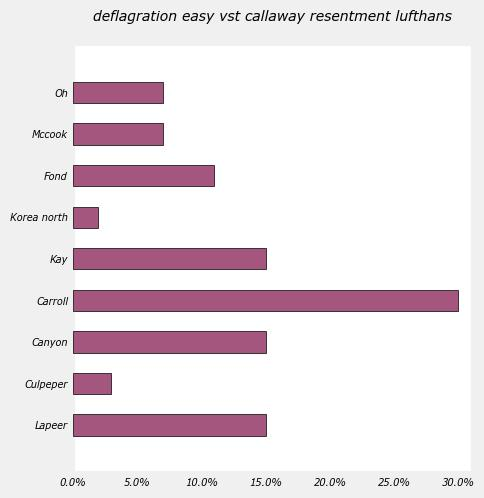

[{"x": 10.0, "y": "Oh"}, {"x": 10.0, "y": "Mccook"}, {"x": 10.0, "y": "Fond"}, {"x": 0.0, "y": "Korea north"}, {"x": 20.0, "y": "Kay"}, {"x": 30.0, "y": "Carroll"}, {"x": 20.0, "y": "Canyon"}, {"x": 0.0, "y": "Culpeper"}, {"x": 20.0, "y": "Lapeer"}]


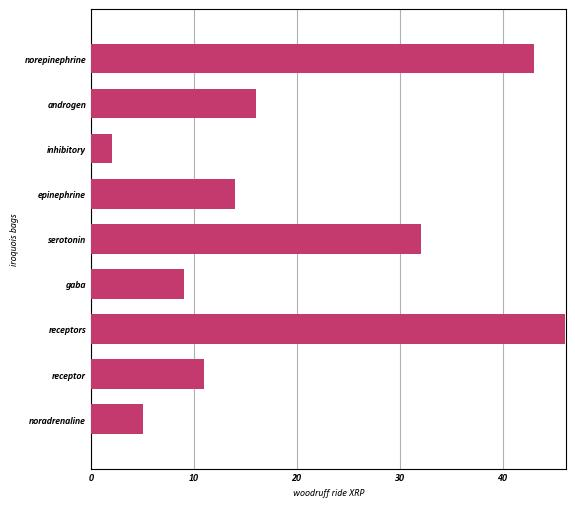

[{"x": 40.0, "y": "norepinephrine"}, {"x": 20.0, "y": "candrogen"}, {"x": 0.0, "y": "inhibitory"}, {"x": 10.0, "y": "epinephrine"}, {"x": 30.0, "y": "serotonin"}, {"x": 10.0, "y": "gaba"}, {"x": 50.0, "y": "receptors"}, {"x": 10.0, "y": "receptor"}, {"x": 0.0, "y": "noradrenaline"}]


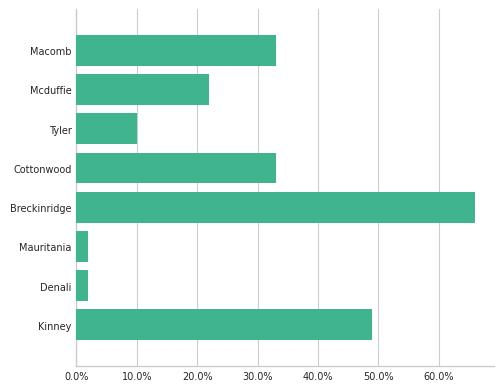

[{"x": 30.0, "y": "Macomb"}, {"x": 20.0, "y": "Mcduffie"}, {"x": 10.0, "y": "Tyler"}, {"x": 30.0, "y": "Cottonwood"}, {"x": 60.0, "y": "Breckinridge"}, {"x": 0.0, "y": "Mauritania"}, {"x": 0.0, "y": "Denali"}, {"x": 50.0, "y": "Kinney"}]


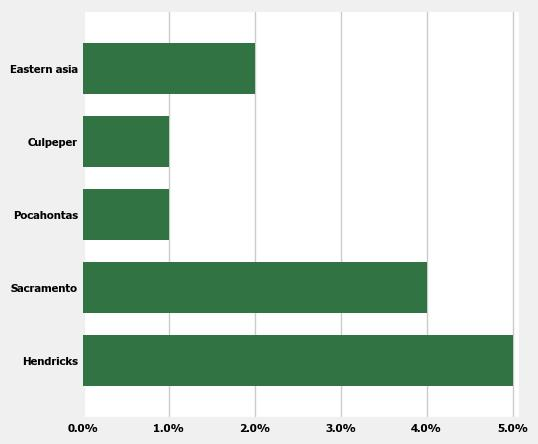

[{"x": 2.0, "y": "Eastern asia"}, {"x": 1.0, "y": "Culpeper"}, {"x": 1.0, "y": "Pocahontas"}, {"x": 4.0, "y": "Sacramento"}, {"x": 5.0, "y": "Hendricks"}]


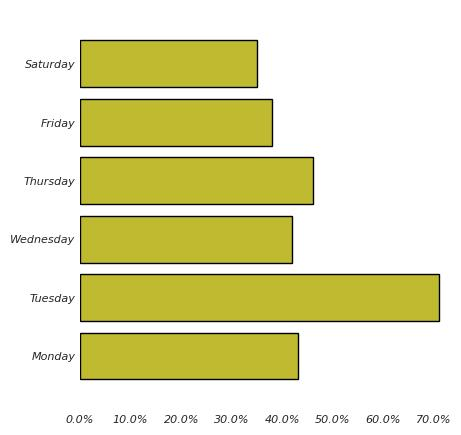

[{"x": 35.0, "y": "Saturday"}, {"x": 38.0, "y": "Friday"}, {"x": 45.0, "y": "Thursday"}, {"x": 41.0, "y": "Wednesday"}, {"x": 71.0, "y": "Tuesday"}, {"x": 43.0, "y": "Monday"}]


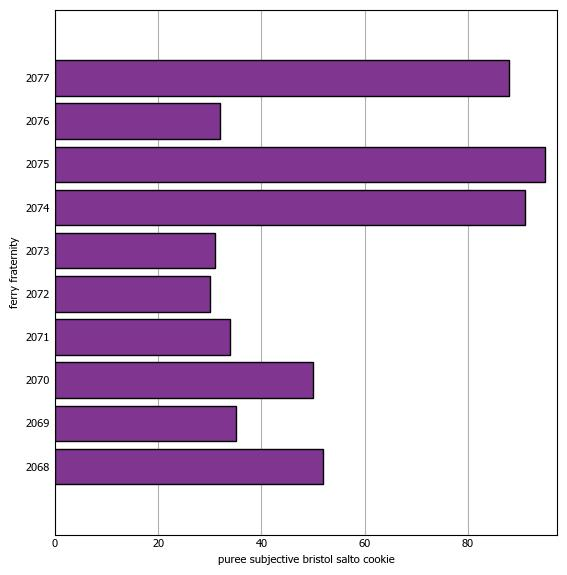

[{"x": 90.0, "y": "2077"}, {"x": 30.0, "y": "2076"}, {"x": 100.0, "y": "2075"}, {"x": 90.0, "y": "2074"}, {"x": 30.0, "y": "2073"}, {"x": 30.0, "y": "2072"}, {"x": 30.0, "y": "2071"}, {"x": 50.0, "y": "2070"}, {"x": 40.0, "y": "2069"}, {"x": 50.0, "y": "2068"}]


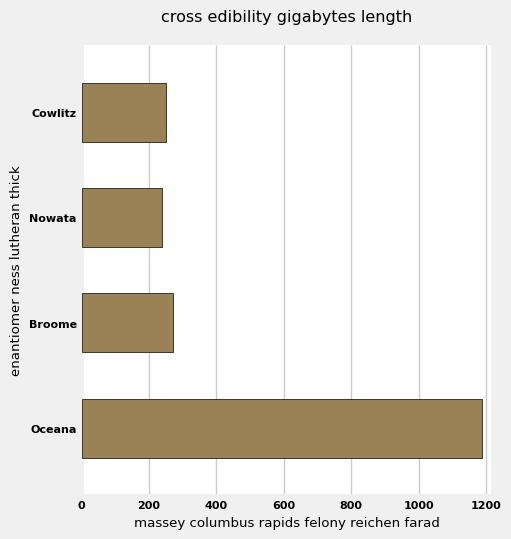

[{"x": 200.0, "y": "Cowlitz"}, {"x": 200.0, "y": "Nowata"}, {"x": 300.0, "y": "Broome"}, {"x": 1200.0, "y": "Oceana"}]


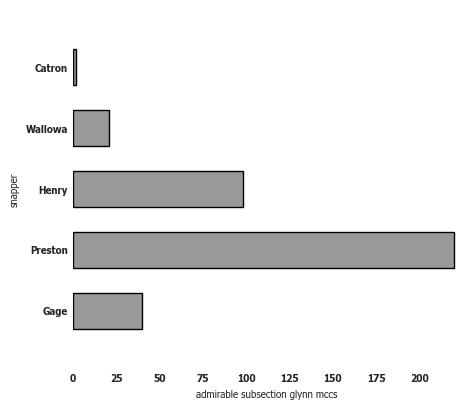

[{"x": 0.0, "y": "Catron"}, {"x": 0.0, "y": "Wallowa"}, {"x": 100.0, "y": "Henry"}, {"x": 200.0, "y": "Preston"}, {"x": 0.0, "y": "Gage"}]


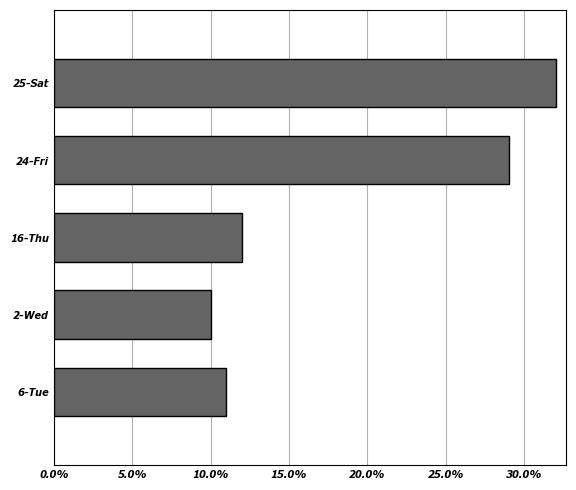

[{"x": 32.0, "y": "25-Sat"}, {"x": 29.0, "y": "24-Fri"}, {"x": 12.0, "y": "16-Thu"}, {"x": 10.0, "y": "2-Wed"}, {"x": 11.0, "y": "6-Tue"}]


In [12]:
print("start loop:")
for i in range(84360, 84401):
    image_path = f"/kaggle/input/benetech-extra-generated-data/graphs_h/{i}.jpg"
    try:
        image = Image.open(image_path)
        display(image)
        inputs = processor(images=image, text="Generate data series:", return_tensors="pt")
        
        # Move inputs to GPU
        inputs = {key: value.to(device) for key, value in inputs.items()}
        
        predictions = model.generate(**inputs, max_new_tokens=2048)
        print(processor.decode(predictions[0], skip_special_tokens=True))
    except FileNotFoundError:
        print(f"Image not found: {image_path}")
    except Exception as e:
        print(f"Error processing {image_path}: {e}")